<a href="https://colab.research.google.com/github/madhavamk/computational-data-science/blob/master/MiniProjects/M7_NB_MiniProject_1_Movielens_Cassandra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science
## A program by IISc and TalentSprint
### Mini-Project: Movielens data querying and analysis using NoSQL Database

## Problem Statement

Using the Cassandra NoSQL database, explore the **Movielens** dataset and build a movie recommendation engine

## Learning Objectives

At the end of the mini-project, you will be able to :

* understand the concepts of NoSQL platforms
* implement the database connectivity using Cassandra
* create and insert data to the database
* perform querying, retrieving and analyzing the data from database

### Dataset

The dataset chosen for this mini-project is [Movielens Dataset](https://movielens.org/). The dataset describes movies and ratings from Movielens. It contains movies from year 1919 to 2000 of total 3883 movies. There are 6040 users who have rated one or more than one movie of total 1000209 ratings collected. Movielens is maintained by members of GroupLens Research at the University of Minnesota. There are 3 datasets given, and they are:

1. `data_movie.csv` that contains movies information:

* MovieId
* Title
* Genres

2. `data_rating.csv` that contains ratings of movies by users:

* UserId
* MovieId
* Rating

3. `data_users.csv` that contains users information:

* UserId
* Age
* Gender

## Information

#### NoSQL platforms

A NoSQL database provides a mechanism for storage and retrieval of data that is modeled in a form other than the tabular relations used in relational databases.

**Cassandra**

Apache Cassandra is a free and open-source, distributed, wide-column store, NoSQL database management system designed to handle large amounts of data across many commodity servers, providing high availability with no single point of failure. It is a NOSQL database developed by Facebook. It is a great database that allows you to effectively run queries on large amount of structured and semi structured data.

To know when you have to choose Cassandra as your database of choice, you need to have an understanding of CAP Theorem.

CAP theorem states that it is impossible for a distributed system to satisfy all three of these guarantees together, you need to leave one out.

- C is Consistency, means all nodes have the same data at the same time
- P is partition tolerance, means that in case of failure the system continues to operate
- A is availability , make sure every request receives a response

![img](https://developer.ibm.com/developer/default/tutorials/ba-set-up-apache-cassandra-architecture/images/figure1.png)

### Components of Cassandra

There are following components in the Cassandra

![img](https://www.guru99.com/images/cassandra/021116_0524_CassandraAr1.png)

**Node**
Node is the place where data is stored. It is the basic component of Cassandra.

**Data Center**
A collection of nodes are called data center. Many nodes are categorized as a data center.

**Cluster**
The cluster is the collection of many data centers.

**Commit Log**
Every write operation is written to Commit Log. Commit log is used for crash recovery.

**Mem-table**
After data written in Commit log, data is written in Mem-table. Data is written in Mem-table temporarily.

**SSTable**
When Mem-table reaches a certain threshold, data is flushed to an SSTable disk file.

### Data Replication

As hardware problem can occur or link can be down at any time during data process, a solution is required to provide a backup when the problem has occurred. So data is replicated for assuring no single point of failure.

Cassandra places replicas of data on different nodes based on these two factors.
- Where to place next replica is determined by the Replication Strategy.
- While the total number of replicas placed on different nodes is determined by the Replication Factor.

One Replication factor means that there is only a single copy of data while three replication factor means that there are three copies of the data on three different nodes.

## Grading = 10 Points

**Install the cassandra-driver**

In [1]:
!pip install cassandra-driver

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 31.1 MB/s eta 0:00:00


#### Importing Necessary Packages

In [2]:
import pandas as pd
import cassandra
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider
from matplotlib import pyplot as plt

In [4]:
print(cassandra.__version__)

3.29.2


### Database connection (2 points)

**Astra Datastax login:** Please refer to this [document](https://cdn.iisc.talentsprint.com/CDS/DB_Connect_Docs/Datastax_Connect.pdf) for account creation on DataStax

**Connect the database and create keyspace:**

* Download Secure Connect Bundle zip file from Datastax [connect](https://docs.datastax.com/en/astra/docs/obtaining-database-credentials.html) section. Follow the instructions on the page
* Upload the `Secure-connect-XXXX.zip` file, which is downloaded from datastax.
* Generate the token and save the credentials from settings section.
    - Hint: Select role as `admin-user` and generate token
* Using the credentials generated in settings, specify the `client Id` and `Client Secret` to the variables below.

In [3]:
#@title Download bundle zip
!wget -qq https://cdn.exec.talentsprint.com/static/cds/content/secure_connect_cds_mov_database.zip
!wget -qq https://cdn.exec.talentsprint.com/static/cds/content/data_movies.csv
!wget -qq https://cdn.exec.talentsprint.com/static/cds/content/data_ratings.csv
!wget -qq https://cdn.exec.talentsprint.com/static/cds/content/data_users.csv

In [8]:
from google.colab import files
files.upload()

{}

set the `Secure connect bundle zip file` path and specify the `clientID` and `Client_Secret`

Note: Credentials used are from CDS account on Datastax

**Database details:**

Database name: cds_mov_database

Namespace name: cds_mov

Collection name: cds_mov_collection

Collection name: cds_rating_collection

Collection name: cds_user_collection

zip_path = '/content/secure_connect_cds_mov_database.zip'

Client_ID = '***'

Client_Secret = '***'

In [5]:
# Enter the credentials below
from google.colab import userdata

zip_path = '/content/secure-connect-cds.zip'
Client_ID = userdata.get('dbClientId')
Client_Secret = userdata.get('dbClientSecret')

#### Create a Cluster instance to connect to your Astra database.

You will typically have one instance of Cluster for each Cassandra cluster you want to interact with. Create a session object using the cluster.

**Hint:** Refer Python documentation under Connect.

In [6]:
cloud_config= {
        'secure_connect_bundle': zip_path
}
auth_provider = PlainTextAuthProvider(Client_ID,
                                      Client_Secret)
cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider)
session = cluster.connect()

#### Verifying the database connection

execute a simple query and verify the database connection

In [7]:
# YOUR CODE HERE
session.execute("select release_version from system.local")

#### Setting the Key Space

A keyspace is the top-level database object that controls the replication for the object it contains at each datacenter in the cluster. Keyspaces contain tables, materialized views and user-defined types, functions and aggregates. Typically, a cluster has one keyspace per application. Since replication is controlled on a per-keyspace basis, store data with different replication requirements (at the same datacenter) in different keyspaces.

Before creating tables and inserting data let's create and set the keyspace

* we can create keyspace manually on Datastax dashboard or also using the CQL command. (use lowercase to avoid errors)

    * [Hint](https://docs.datastax.com/en/cql-oss/3.x/cql/cql_reference/cqlCreateKeyspace.html)

* once the keyspace is created successfully, set the keyspace using the command `set_keyspace()`

In [8]:
# YOUR CODE HERE
session.set_keyspace('movielens')

### Insert the data into Database (1 point)

To insert the data into database, we can create a table in keyspace and insert the data by using CQL command or we can directly upload the data on the datstax dashboard using [Astra Dataloader](https://docs.datastax.com/en/astra/docs/develop/dev-upload-data.html)

As there is huge amount of data, insertion of data using CQL commands may take time, preferable method is Astra Dataloader.

* Download the below mentioned 3 datasets and upload to Datastax Astra dashboard using Astra Dataloader
    * [data_movies](https://cdn.iisc.talentsprint.com/CDS/MiniProjects/data_movies.csv)
    * [data_ratings](https://cdn.iisc.talentsprint.com/CDS/MiniProjects/data_ratings.csv)
    * [data_users](https://cdn.iisc.talentsprint.com/CDS/MiniProjects/data_users.csv)
    
while uploading data using Datastax Astra dataloader you may encounter the below error message due to formatting issues or bulk data. In that case, click on upload button for second time for data upload.
![img](https://cdn.iisc.talentsprint.com/CDS/MiniProjects/data_upload_error.JPG)

Note: Cassandra also handles non-SQL data formats such as JSON (see [insert JSON data](https://docs.datastax.com/en/cql-oss/3.3/cql/cql_using/useInsertJSON.html)). However for the purpose of this Mini-project, we are using a tabular data format (.csv).

### Loading the data


In [9]:
# YOUR CODE HERE
# Use pd.read_csv('data_movies.csv')
data_movies = pd.read_csv('data_movies.csv')

In [10]:
# YOUR CODE HERE
# Use pd.read_csv('data_ratings.csv')
data_ratings = pd.read_csv('data_ratings.csv')

In [11]:
# YOUR CODE HERE
# Use pd.read_csv('data_users.csv')
data_users = pd.read_csv('data_users.csv')

### Querying the database (2 points)

* Select First 10 rows of the data_movies table
* How many Users have watched the movie  `'Contact (1997)'` with MovieId = 1584
* Select the count of teenage male users

**Note:** For syntax related issues, try the **CQLConsole** on Datastax dashboard

**Hint:** [CQL command for select](https://docs.datastax.com/en/cql-oss/3.3/cql/cql_using/useQueryColumnsSort.html)

#### Creating the data_movies table

In [12]:
# Use the following SQL query:
# query = """CREATE TABLE  IF NOT EXISTS data_movies (movieid INT,
#                                                 title TEXT,
#                                                 genres TEXT,
#                                                 PRIMARY KEY (movieid)); """

# YOUR CODE HERE
query = """CREATE TABLE  IF NOT EXISTS data_movies (movieid INT,
                                                 title TEXT,
                                                 genres TEXT,
                                                 PRIMARY KEY (movieid)); """

In [ ]:
data_movies_cols = ','.join(data_movies.columns.values)
for (i,row) in data_movies.iterrows():
   query = 'INSERT INTO movielens.data_movies ({}) VALUES (%s, %s, %s)'.format(data_movies_cols)
   session.execute(query, tuple(row))

**Please note that the above code cell will take around 6 mins 30 secs to complete execution on CPU**

#### Creating the data_ratings table

In [ ]:
# Use the following SQL query:
query = """CREATE TABLE  IF NOT EXISTS data_ratings (movieid INT,
                                                rating INT,
                                                userid INT,
                                                PRIMARY KEY (movieid)); """
# YOUR CODE HERE

**Limiting the DataFrame to the first 5000 rows**

In [ ]:
# Limiting the DataFrame to the first 5000 rows
data_ratings = data_ratings.head(5000)  # Replace 'data_ratings' with your actual DataFrame

In [ ]:
# Preparing to insert only the first 5000 rows
data_ratings_cols = ','.join(data_ratings.columns.values)
# Use the following:
insert_query = f"INSERT INTO movielens.data_ratings ({data_ratings_cols}) VALUES (%s, %s, %s)"

# Insert the 5000 rows into Cassandra table 'data_ratings'
# YOUR CODE HERE
for (i,row) in data_ratings.iterrows():
   query = insert_query.format(data_ratings_cols)
   session.execute(query, tuple(row))

**Please note that the above code cell will take around 8 mins 26 secs to complete execution on CPU**

#### Creating the data_users table

In [ ]:
# Use the following SQL query:
query = """CREATE TABLE  IF NOT EXISTS data_users (userid INT,
                                                gender TEXT,
                                                age INT,
                                                PRIMARY KEY (userid)); """

In [ ]:
data_users_cols = ','.join(data_users.columns.values)
for (i,row) in data_users.iterrows():
   query = 'INSERT INTO movielens.data_users ({}) VALUES (%s, %s, %s)'.format(data_users_cols)
   session.execute(query, tuple(row))

**Please note that the above code cell will take around 10 mins 11 secs to complete execution on CPU**

* Select First 10 rows of the data_movies table

In [14]:
# YOUR CODE HERE
query = 'select * from movielens.data_movies limit 10'
rows = session.execute(query)
for row in rows:
    print(row)

Row(movieid=3372, genres='Action|War', title='Bridge at Remagen, The (1969)')
Row(movieid=1584, genres='Drama|Sci-Fi', title='Contact (1997)')
Row(movieid=2731, genres='Drama', title='400 Blows, The (Les Quatre cents coups) (1959)')
Row(movieid=2713, genres='Horror|Thriller', title='Lake Placid (1999)')
Row(movieid=769, genres='Documentary', title='Marlene Dietrich: Shadow and Light (1996)')
Row(movieid=1863, genres='Comedy', title='Major League: Back to the Minors (1998)')
Row(movieid=2453, genres='Drama|Fantasy', title='Boy Who Could Fly, The (1986)')
Row(movieid=2302, genres='Comedy', title='My Cousin Vinny (1992)')
Row(movieid=3733, genres='Drama', title='Paper Chase, The (1973)')
Row(movieid=1765, genres='Crime|Drama', title='Letter From Death Row, A (1998)')


* How many Users have watched the movie 'Contact (1997)' with MovieId = 1584

**Hint:** Use the following query command.

"SELECT count(*) FROM cds_mov.data_ratings WHERE movieid=1584 ALLOW FILTERING;"

In [15]:
# YOUR CODE HERE
query_cnt = 'SELECT count(*) FROM movielens.data_ratings WHERE movieid=1584 ALLOW FILTERING'
cnt = session.execute(query_cnt)
print("Number of users who watched movie 'Contact' with id 1584 is ",cnt.one().count)

Number of users who watched movie 'Contact' with id 1584 is  1


* Select the count of teenage male users

**Hint:** Use the following query command.

"""select count(*) from cds_mov.data_users where age<20 and gender='M' allow filtering;"""

In [16]:
# YOUR CODE HERE
query_cnt = 'select count(*) from movielens.data_users where age<20 and gender=\'M\' allow filtering;'
cnt = session.execute(query_cnt)
print("Count of teenage male users is ",cnt.one().count)

Count of teenage male users is  949


* Select the count of movies with Top rating from the entire ratings table

In [17]:
# YOUR CODE HERE
query = 'select count(*) from movielens.data_ratings where rating=5 allow filtering'
cnt = session.execute(query)
print("Count of movies with Top rating is ",cnt.one().count)

Count of movies with Top rating is  572


* Select the count of movies, ONLY in Comedy genre from the entire data_movies table

In [18]:
# YOUR CODE HERE
query = 'select count(*) from movielens.data_movies where genres=\'Comedy\' allow filtering'
cnt = session.execute(query)
print("Count of movies in Comedy genre is ",cnt.one().count)

Count of movies in Comedy genre is  521


### Visualizing the Data (2 points)

Retrieve the data using CQL queries and visualize using matplotlib

* Visualize the frequencies of movie genres from the entire data

**Hint:** Use the following query

query = 'select genres from cds_mov.data_movies'

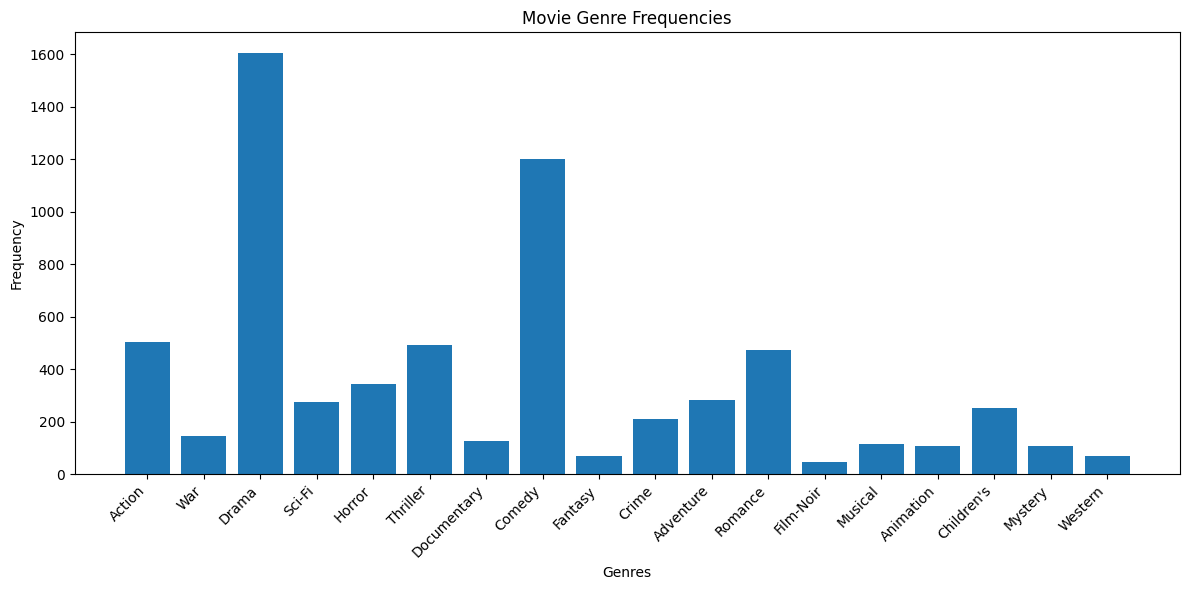

In [19]:
# YOUR CODE HERE
query = 'select genres from movielens.data_movies'
genres = session.execute(query)

from collections import defaultdict

# Execute the query to retrieve genres
query = 'select genres from data_movies'
rows = session.execute(query)

# Create a dictionary to store genre frequencies
genre_frequencies = defaultdict(int)

# Process each row to count genre occurrences
for row in rows:
    genres = row.genres.split('|')  # Split genres based on '|' delimiter
    for genre in genres:
        genre_frequencies[genre] += 1

# Prepare data for plotting
genres = list(genre_frequencies.keys())
frequencies = list(genre_frequencies.values())

# Create the bar plot
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.bar(genres, frequencies)
plt.xlabel("Genres")
plt.ylabel("Frequency")
plt.title("Movie Genre Frequencies")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

* Visualize the bar plot showing no.of movies released in a particular year

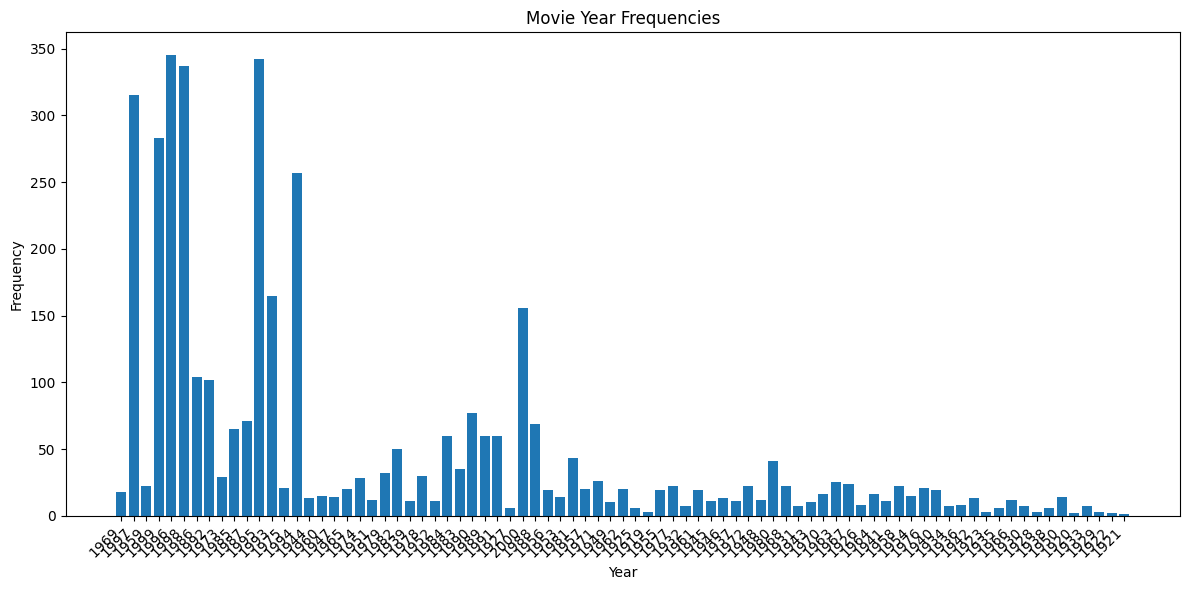

In [20]:
# YOUR CODE HERE
import re
def extract_year(movie_title):
    # Regex to find a 4-digit number inside parentheses
    match = re.search(r'\((\d{4})\)', movie_title)
    if match:
        return match.group(1)  # Return the matched year
    else:
        return None  # Return None if no year found

query = 'select title from movielens.data_movies'
rows = session.execute(query)

# Create a dictionary to store genre frequencies
year_frequencies = defaultdict(int)

# Process each row to count genre occurrences
for row in rows:
    year = extract_year(row.title)  # Split genres based on '|' delimiter
    year_frequencies[year] += 1

# Prepare data for plotting
years = list(year_frequencies.keys())
frequencies = list(year_frequencies.values())

# Create the bar plot
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.bar(years, frequencies)
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.title("Movie Year Frequencies")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

* Depict the plot of Age groups ratio who are active in watching movies

**Hint:** Use the following query.

query = 'select age from cds_mov.data_users;'

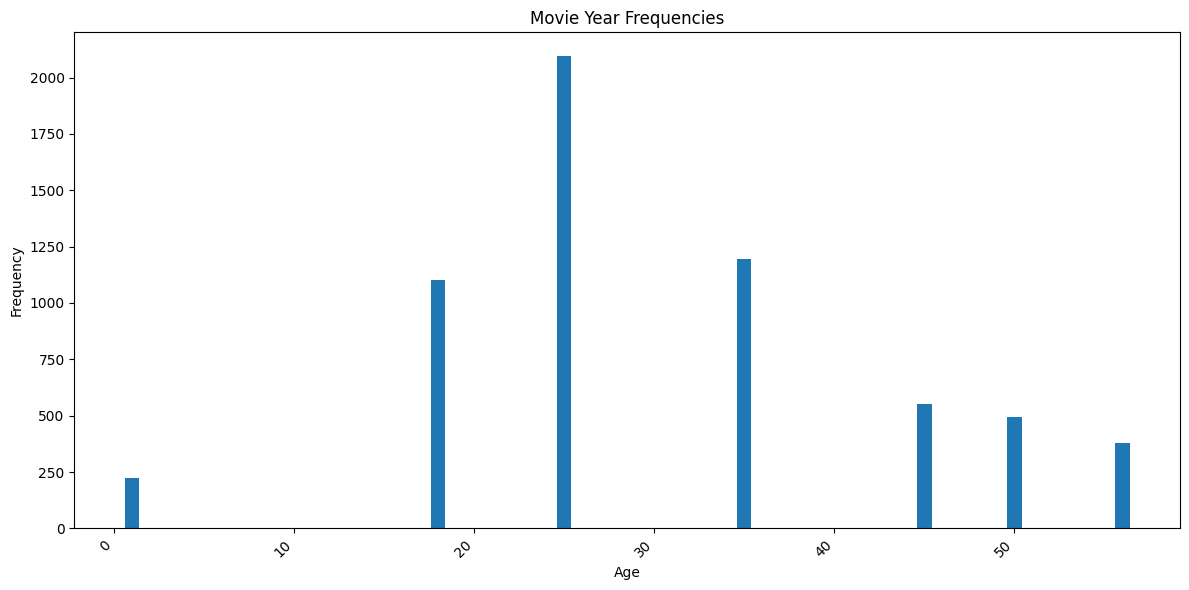

In [21]:
# YOUR CODE HERE
query = 'select age from movielens.data_users'
rows = session.execute(query)

# Create a dictionary to store genre frequencies
age_frequencies = defaultdict(int)

# Process each row to count genre occurrences
for row in rows:
    age = row.age  # Split genres based on '|' delimiter
    age_frequencies[age] += 1

# Prepare data for plotting
ages = list(age_frequencies.keys())
frequencies = list(age_frequencies.values())

# Create the bar plot
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.bar(ages, frequencies)
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Movie Year Frequencies")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

### Analyzing the Data (3 points)

Analyzing the correlation between the movies records, implement a function to recommend movies based on search term

* Retrieve all the data from ratings table

**Hint:** Use the following query.

query = 'select * from cds_mov.data_ratings;'

In [22]:
# YOUR CODE HERE
query = 'select * from movielens.data_ratings'
rows = session.execute(query)
print(rows.one())


Row(movieid=3372, rating=2, userid=4510)


* Create a movie matrix by applying pivot table with the above retrieved ratings data

* use `pd.pivot_table` with index = `userid`, columns = `movieid` and Values = `rating`

 **Hint:** create a dataframe with above retrieved ratings data to apply pivot table

In [23]:
# YOUR CODE HERE
data = [dict(row._asdict()) for row in rows]

# Create DataFrame
df = pd.DataFrame(data)

print(df.head())
movie_matrix = df.pivot_table(index='userid', columns='movieid', values='rating')


   movieid  rating  userid
0     3372       2    4510
1     1584       5     436
2     2731       5    3371
3     2713       1    3683
4      769       3    1150


* Define a function named `recommend_movies()` which will take a movieid as argument and return the top 5 similar movieid's

    * Considering the argument (movieid) as search item collect the particular row data
    
    * Using movie matrix calculate correlation between movie search Item data and all the remaining data
    
        * Hint: [corr_with()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corrwith.html)
        
    * Sort the result by ascending order and return the top 5 items

In [25]:
def recommend_movie(movie_matrix,movieId):
    # YOUR CODE HERE
    movie_correlations = movie_matrix.corrwith(movie_matrix[movieId])

    # Sort the correlations in descending order and return the top 5 (excluding the movie itself)
    top_recommendations = movie_correlations.sort_values(ascending=False).index[1:6]

    return top_recommendations

#print(recommend_movie(df, 6040))
print(recommend_movie(movie_matrix, 3372))
#movie_matrix[3372]

Index([2, 3, 4, 5, 6], dtype='int64', name='movieid')


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


* write a query to get MovieId of a Title (your choice) and the result MovieId as a search item by calling the above defined function

In [26]:
# YOUR CODE HERE
query = "select movieid from movielens.data_movies where title = 'Bridge at Remagen, The (1969)'  ALLOW FILTERING"
rows = session.execute(query)
print(rows.one())
recommendations = recommend_movie(movie_matrix, 3372)
print(recommendations)


Row(movieid=3372)
Index([2, 3, 4, 5, 6], dtype='int64', name='movieid')


* Now taking the result of top 5 items (MovieId's) write a query to retrieve the Movie title from movies table

In [27]:
# YOUR CODE HERE
for r in recommendations:
    query = "select title from movielens.data_movies where movieid = {}  ALLOW FILTERING".format(r)
    rows = session.execute(query)
    print(rows.one())

Row(title='Jumanji (1995)')
Row(title='Grumpier Old Men (1995)')
Row(title='Waiting to Exhale (1995)')
Row(title='Father of the Bride Part II (1995)')
Row(title='Heat (1995)')


**Close the session**

In [28]:
# YOUR CODE HERE
session.shutdown()